# Hierarchical and low-rank techniques

Some processes are represented by dense matrices that have structured representations.  The most common technique is to approximate blocks using a truncated SVD $U S V^T$.

Inverses of differential operators sometimes have this property.

<IPython.core.display.Javascript object>


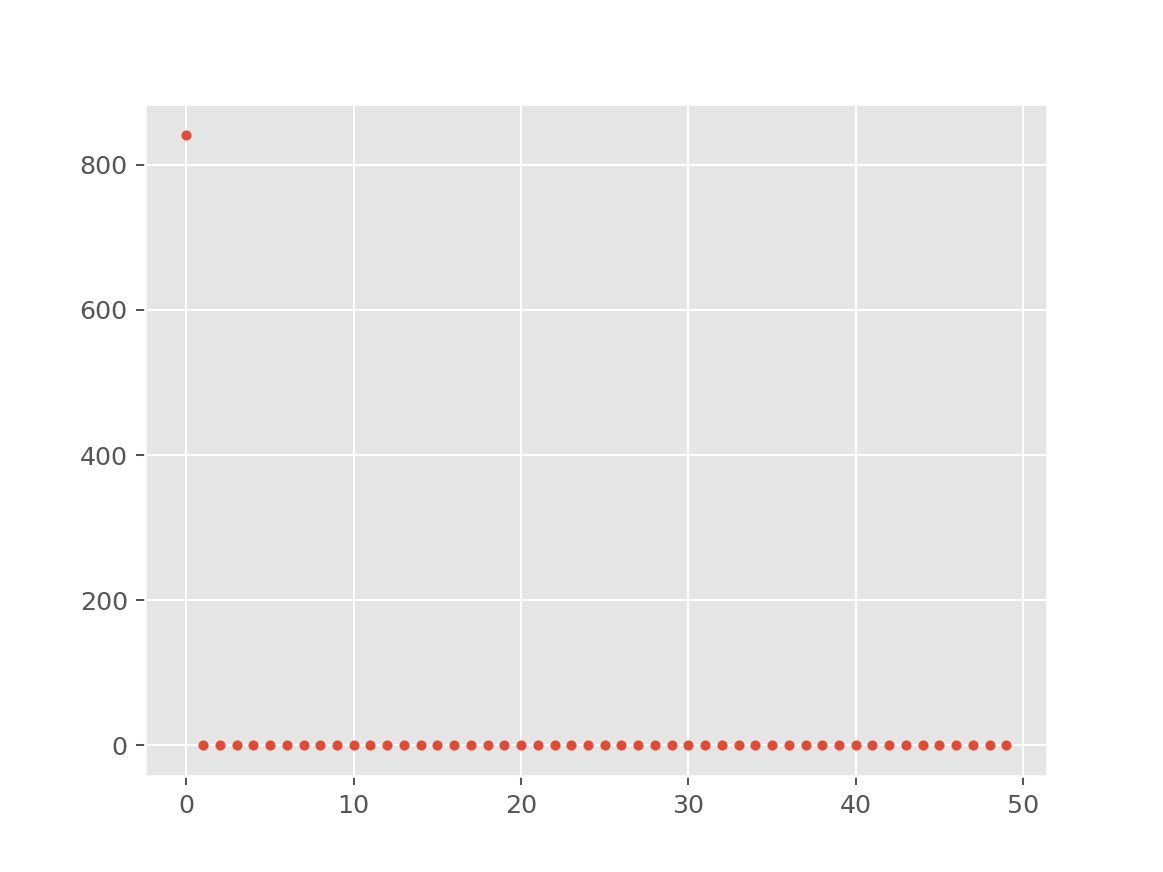

In [12]:
%matplotlib notebook
import numpy

m = 101
A = numpy.eye(m) - .5*numpy.eye(m,k=1) - .5*numpy.eye(m,k=-1)
#A[-1,-1] = 0.5
Ainv = numpy.linalg.inv(A)

B = Ainv[:m//2,m//2+1:]
U, S, V = numpy.linalg.svd(B)

from matplotlib import pyplot
pyplot.style.use('ggplot')
pyplot.figure()
pyplot.plot(S, '.')

<IPython.core.display.Javascript object>


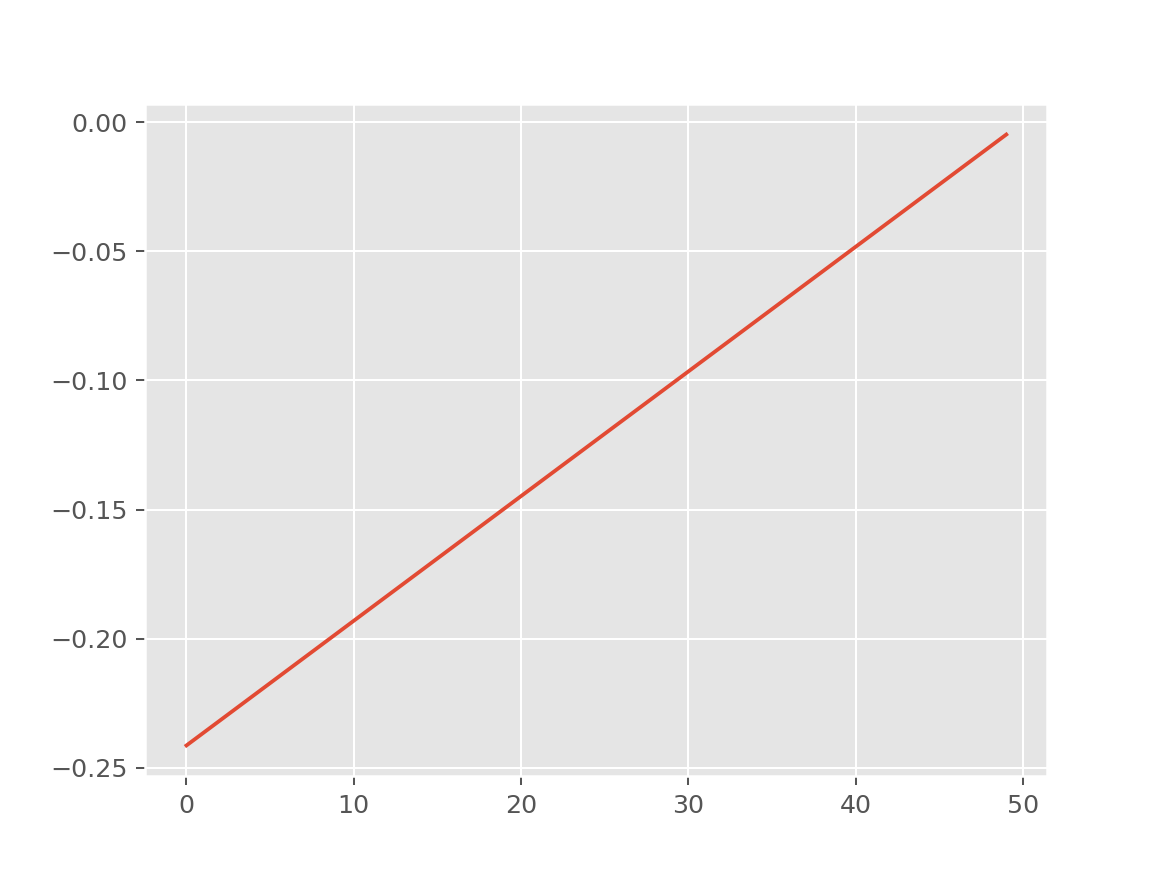

In [13]:
pyplot.figure()
pyplot.plot(V.T[:,0])

## Particle interactions

The gravitational (or electrostatic) force between particles is proportional to $1/|r|^2$ where $r$ is the distance between them.  The direction of this force is in the direction $r$ with magnitude equal to the product of the masses (or charges).  Let's consider two separated groups of particles.

<IPython.core.display.Javascript object>


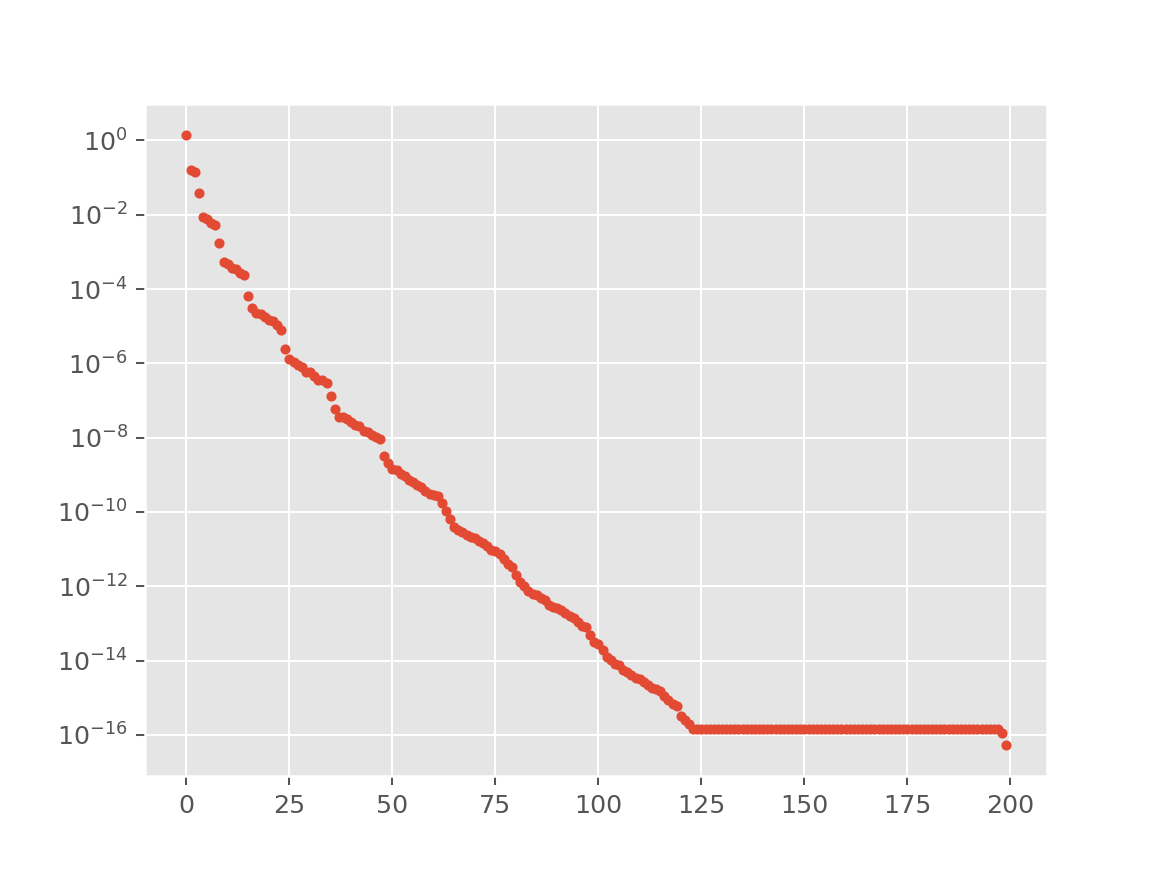

In [18]:
m, n = 100, 200
x = numpy.random.randn(m,3)  # first cluster of particle locations
y = numpy.random.randn(n,3)
y[:,0] += 10 # second cluster is translated away

A = numpy.zeros((3*m,n))
for i in range(m):
    r = y.T - numpy.outer(x[i,:], numpy.ones(n))
    A[3*i:3*i+3, :] = r / numpy.linalg.norm(r, axis=0)**3

U, S, V = numpy.linalg.svd(A, full_matrices=False)

pyplot.figure()
pyplot.semilogy(S, '.')

## Treecodes to FMM

Treecodes were introduced by [Barnes and Hut in 1986](http://www.nature.com/nature/journal/v324/n6096/abs/324446a0.html) and have been a staple in cosmology simulation ever since, as exemplified by [Warren's SC13 paper](http://cacs.usc.edu/education/cs653/Warren-2HOT-SC13.pdf).  Each particle "sees" close neighbors (shaded region) directly while distant neighbors are approximated by their multipole expansions on increasingly coarse "boxes".  Tuning parameters include the box size, the degree of the multipole expansion, and the threshold angle $\theta$ (distant boxes must lie within this angle to use a multipole expansion -- thus it describes the coarsening rate).  Treecodes have $O(n \log n)$ complexity and typically small constants for modest accuracy requirements (the constants increase as the accuracy tolerance becomes stricter).

![Treecode from Warren SC13](figures/Warren-Treecode.png)

The Fast Multipole Method (FMM) was introduced by [Greengard and Rokhlin in 1987](https://web.stanford.edu/class/cme324/classics/greengard-rokhlin.pdf) and is an $O(n)$ algorithm that often outperforms treecodes for strict accuracy requirements.  It differs in that particles do not directly interact with distant particles; instead, the (outward-looking) multipole expansions interact and are used to create (inward-looking) "local" expansions.  [Yokota and Barba (2012)](https://arxiv.org/pdf/1106.2176.pdf) provide a prospectus for FMM optimization on emerging architectures.

![FMM from Yokota and Barba](figures/YokotaBarba-FMM.png)

Classical FMM uses analytic descriptions of the "kernel" (the force relationship) and requires analytic methods to compute the multipole and local interactions.  At (typically) some moderate overhead, these can be computed numerically using only the kernel $K(r) = 1/r$ (for example), using the "kernel-independent FMM" introduced by Anderson (1992) and refined by [Ying, Biros, Zorin, and Langstron (2003)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.650.6495&rep=rep1&type=pdf). In these methods, a number of "check points" are used to map from the original particles to a set of "equivalent points" (left), to upscale those to coarser multipole expansions (middle), and to form local expansions (right).

![KIFMM from Ying et al](figures/YingAO-KIFMM.png)


## Structured matrices

Low rank matrices (or blocks thereof) are typically represented using a reduced SVD

$$ A \approx U \Sigma V^T $$

where $U$ has only $k \ll n$ columns.  We are often given an operator that we can apply, but for which we don't have direct access to the entries (or direct access would be too slow).  An example is a block of the inverse of a PDE operator, e.g., applied via multigrid.

### Randomized SVD

Given an orthogonal $m\times k$ matrix $Q$ that represents most of the energy of the $m \times n$ matrix $A$, in the sense that $A \approx Q Q^T A$, we can compute an approximate SVD of $A$ using the following steps:

1. Compute $B = Q^T A$, a $k\times n$ matrix
2. Compute the SVD $B = \hat U \Sigma V^T$
3. Let $U = Q \hat U$

This factorization satisfies

$$ U \Sigma V^T = Q (\hat U \Sigma V^T) = Q Q^T A \approx A . $$

But how do we identify the subspace $Q$?  One popular method with an elegant theory (e.g., [Halko, Martinsson, Tropp (2011)](http://epubs.siam.org/doi/pdf/10.1137/090771806)) is to choose a random $m \times k$ matrix $X$ and run a power iteration on the normal equations

1. $Y = A (A^T A)^q X$
2. $QR = Y$ (discard $R$ and use $Q$ in the algorithm above)

### Factorization preconditioners

Schur complements in PDE solvers often have low-rank structure away from the diagonal.  Since factoring these dense "supernodes" is the bottleneck for sparse direct solvers, an attractive option is to approximate them using structured matrix representations.
[STRUMPACK](http://portal.nersc.gov/project/sparse/strumpack/) is a package available in PETSc that is based on these principles.
* `-pc_type lu -pc_factor_mat_solver_package strumpack`
* `-pc_type ilu -pc_factor_mat_solver_package strumpack`